## 뉴스 요약봇 만들기

### 학습 목표
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

### 루브릭 
- Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. : **분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.**
- 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. : **모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.**
- Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. : **두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.**

## 목차
### 1. 데이터 준비
### 2. 데이터 전처리
#### 1) 중복값, 결측값 제거
#### 2) 정규화와 불용어 제거
#### 3) 텍스트 길이 결정 및 시작/종료 토큰 추가
#### 4) 훈련데이터와 테스트데이터 나누기
#### 5) 정수 인코딩(토큰화)
### 3. 모델 설계
#### 1) 인코더 설계
#### 2) 디코더 설계
#### 3) 모델 정의 및 훈련
#### 4) 인퍼런스 모델 구현
### 4. 추상적 요약과 원문 비교
### 5. 추출적 요약과 원문 비교
---

## 1. 데이터 준비

In [2]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
len(data)

98401

## 2. 데이터 전처리

In [5]:
import nltk
nltk.download('stopwords')

import numpy as np
import os, re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords    # 불용어(NLTK에서 제공하는 리스트 사용)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


추상적 요약: 원문으로부터 내용이 요약된 새로운 문장을 생성하는  자연어 생성(Natural Language Generation, NLG)문제에 해당함.
* seq2seq(sequence-to-sequence) 모델 이용: 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델
  * 첫 번째 RNN(인코더): 원문을 컨텍스트 벡터(context vector)로 변환
  * 두 번째 RNN(디코더): 컨텍스트 벡터로부터 한 단어씩을 생성, 요약 문장 도출
  * 디코더는 시작 토큰 SOS가 입력되면 종료 토큰 EOS를 예측할 때까지 각 시점마다 단어를 생성함.

### 1) 중복값, 결측값 제거

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.drop_duplicates(subset = ['headlines'], inplace=True)
len(data)

98262

In [7]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

각 칼럼에서 중복된 값을 삭제하고, 결측값이 없음을 확인하였다.

### 2) 정규화와 불용어 제거
* 인코더가 문맥 정보를 가진 컨텍스트 벡터를 학습하게 하려면 'text'는 그 의미가 명확하게 받아들여지도록 불용어가 제거되어야 한다.
* 디코더가 문장의 시작부터 끝까지 단어를 생성하게 하려면 'headline'의 앞뒤에 시작 토큰 SOS, 종료 토큰 EOS를 붙여 학습시켜야 한다. 또한 자연스러운 문장을 출력하게 하기 위해 불용어는 제거하지 않는다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전 단어 수: ", len(contractions))

정규화 사전 단어 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

서로 같은 단어를 키-값으로 연결지은 딕셔너리 형태로 '정규화 사전'을 정의한다. 불용어는 NLTK에서 제공하고 있는 179개 단어로 정의한다.

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower().strip() # 텍스트 소문자화, 텍스트의 양 옆 공백 제거
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백들은 하나의 공백으로 바꾸기
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환    
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

데이터 전처리 함수를 선언한다. 이때 remove_stopwords라는 인자를 True 또는 False로 입력하여 불용어를 제거할지 하지 않을지 선택할 수 있게 한다.

In [11]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s, True))
    
print(clean_text[:5])

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illne

In [12]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print(clean_headlines[:5])

['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('',np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

'text'에는 불용어를 제거하고, 'headlines'에는 불용어를 제거하지 않는 차이를 두고 전처리 함수를 시행하였다. 전처리 결과 공백이 되는 텍스트는 NaN으로 대체하도록 한 다음, 결측값이 있는지 확인한다.

### 3) 텍스트 길이 결정 및 시작/종료 토큰 추가
* 'text'와 'headlines'의 적절한 길이를 판단하여 통일시킨다,
* 정해진 길이보다 길면 제외시키고, 짧으면 패딩을 붙인다. 입력 데이터의 대다수를 포함할 수 있는 길이로 정하되 최대 길이를 너무 길게 설정할 경우 짧은 시퀀스는 지나치게 많은 패딩을 가지게 되므로 텍스트 길이 분포를 보아 적절히 조정해야 한다.
* 'headlines' 텍스트의 앞뒤에는 시작/종료 토큰을 추가한 다음 패딩을 붙인다.

In [15]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트 길이 최소값:', np.min(text_len))
print('텍스트 길이 최대값:', np.max(text_len))
print('텍스트 길이 평균:', np.mean(text_len))
print('텍스트 길이 중앙값:', np.median(text_len))
print('텍스트 길이 표준편차:', np.std(text_len),'\n')

print('헤드라인 길이 최소값:', np.min(headlines_len))
print('헤드라인 길이 최대값:', np.max(headlines_len))
print('헤드라인 길이 평균:', np.mean(headlines_len))
print('헤드라인 길이 중앙값:', np.median(headlines_len))
print('헤드라인 길이 표준편차:', np.std(headlines_len))

텍스트 길이 최소값: 1
텍스트 길이 최대값: 60
텍스트 길이 평균: 35.2580855264497
텍스트 길이 중앙값: 35.0
텍스트 길이 표준편차: 3.803198572430849 

헤드라인 길이 최소값: 1
헤드라인 길이 최대값: 16
헤드라인 길이 평균: 9.264364657751726
헤드라인 길이 중앙값: 9.0
헤드라인 길이 표준편차: 1.361915062137804


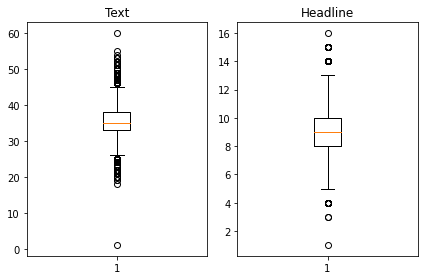

In [16]:
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')

plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headline')

plt.tight_layout()
plt.show()

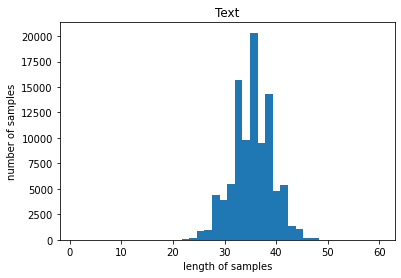

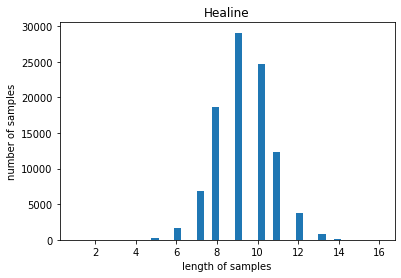

In [17]:
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Healine')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
def under_threshold_len(min_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) >= min_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상인 샘플의 비율: %s'%(min_len, (cnt / len(nested_list))))

In [20]:
text_max_len = 45
text_min_len = 20

below_threshold_len(text_max_len, data['text'])
under_threshold_len(text_min_len, data['text'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9964584478231666
전체 샘플 중 길이가 20 이상인 샘플의 비율: 0.9999592925037145


In [21]:
headline_max_len = 12
below_threshold_len(headline_max_len, data['headlines'])

전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9910036433209175


In [22]:
data = data[data['text'].apply(lambda x: (len(x.split()) <= text_max_len) and (len(x.split()) > text_min_len))]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', len(data))

전체 샘플수 : 97024


'text'는 길이가 20 이상 45이하, 'headlines'는 길이가 12이하인 텍스트만 남기고 제거하였다. ('text'는 뉴스 기사글인 이상 지나치게 짧은 글은 오류일 가능성이 높아 제외했다.)

In [23]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


디코더가 단어 예측을 위해 학습할 'headlines'는 시작 토큰 SOS가 붙은 input 데이터, 종료 토큰 EOS가 붙은 target 데이터로 구분한다. 

### 4) 훈련데이터와 테스트데이터 나누기

In [24]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input']) 
decoder_target = np.array(data['decoder_target'])

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_targer = decoder_target[indices]

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수:', n_of_val)

테스트 데이터의 수: 19404


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77620
훈련 레이블의 개수 : 77620
테스트 데이터의 개수 : 19404
테스트 레이블의 개수 : 19404


'test', 'decoder_input', 'decoder_target' 데이터를 섞은 다음 그의 20%를 테스트 데이터로 분리한다.

### 5) 정수 인코딩(토큰화)

In [28]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

훈련데이터 중, 기사 원문에 해당하는 'encoder_input_train'을 이용해 단어별 정수를 부여한 src_tokenizer를 선언한다.

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기: 69765
등장 빈도가 6번 이하인 희귀 단어의 수: 47669
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 22096
단어 집합에서 희귀 단어의 비율: 68.32795814520175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5587783528592367


* tokenizer.word_index: 단어(키)-부여된 정수(값) dictionary
* tokenizer.word_counts: 단어(키)-단어가 등장한 횟수(값) orderedDict(아이템들의 입력 순서를 기억하는 dictionary 클래스)

In [30]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [31]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

단어 집합 내에서 등장 빈도가 지나치게 적은 단어들은 제외하여, 단어 집합의 크기를 22000으로 줄여 src_tokenizer를 다시 생성한 다음, 'encoder_input_train'과 'encoder_input_test'(기사 원문)를 모두 정수 시퀀스로 바꾼다.
* tokenizer.texts_to_sequences(문자열 배열): 문자열들을 모두 tokenizer 내부의 단어 사전에 맞추어 정수로 변환(정수 인코딩)

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

훈련데이터 중 요약문에 해당하는 'headlines' 중 'decoder_input_train'을 이용해 단어별 정수를 부여한 tar_tokenizer를 선언하고, 같은 과정을 반복한다. 단, 'decoder_input_train'에는 시작 토큰이, 'decoder_target_train'에는 종료 토큰이 존재하므로 tar_tokenizer가 시작/종료 토큰을 인식할 수 있도록 두 배열을 모두 학습해야 한다.

In [33]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기: 30013
등장 빈도가 4번 이하인 희귀 단어의 수: 18532
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 11481
단어 집합에서 희귀 단어의 비율: 61.74657648352381
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.0067095415776235


In [34]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [35]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [36]:
drop_train1 = [index for index, sentence in enumerate(encoder_input_train) if len(sentence) == 1]
drop_test1 = [index for index, sentence in enumerate(encoder_input_test) if len(sentence) == 1]
drop_train2 = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test2 = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 (원문) 훈련 데이터의 개수 :', len(drop_train1))
print('삭제할 (원문) 테스트 데이터의 개수 :', len(drop_test1))
print('삭제할 (요약문) 훈련 데이터의 개수 :', len(drop_train2))
print('삭제할 (요약문) 테스트 데이터의 개수 :', len(drop_test2))

삭제할 (원문) 훈련 데이터의 개수 : 0
삭제할 (원문) 테스트 데이터의 개수 : 0
삭제할 (요약문) 훈련 데이터의 개수 : 0
삭제할 (요약문) 테스트 데이터의 개수 : 0


빈도수가 낮은 단어가 삭제되었으므로 빈도수가 낮은 단어만으로 구성되었던 텍스트는 시작 또는 종료 토큰만 남아 길이가 1인 빈 텍스트가 되었을 수 있고, 이는 삭제시켜야 한다. 원문과 요약문 모두 빈 텍스트는 없음을 확인했다.

In [37]:
text_max_len = 45
headline_max_len = 12

# 인코더 훈련용-기사 원문
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')

# 인코더 테스트용-기사 원문
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

# 디코더 훈련용-요약문
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')

# 디코더 테스트용-요약문
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

기사 원문은 문장 최대 길이 45, 요약문(headlines)은 문장 최대 길이 12로, 그보다 길이가 짧은 문장은 패딩으로 채워 길이를 맞춘다.

## 3. 모델 설계

### 1) 인코더 설계

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

src_vocab = 22000    # 어휘 사전의 크기
embedding_dim = 128    # 워드 벡터의 차원수(단어들의 인덱스를 워드 벡터로 추상화)
hidden_size = 512    # 단어 간의 연관성(맥락)을 파악하기 위한 LSTM의 수용력(뉴런의 개수, 레이어 깊이)

# 입력 레이어
encoder_inputs = Input(shape=(text_max_len,))

# 임베딩 레이어
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 첫번째 LSTM 레이어
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 두번째 LSTM 레이어
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 세번째 LSTM 레이어
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 2) 디코더 설계

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 입력 레이어
decoder_inputs = Input(shape=(None,))

# 임베딩 레이어
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM 레이어
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 레이어
attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 출력 레이어
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

어텐션 레이어:인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
어텐션 결과와 디코더의 hidden state들을 연결

### 3) 모델 정의 및 훈련

In [40]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 512), (N 1312768     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), 
                    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 231s 726ms/step - loss: 6.0307 - val_loss: 5.7725
Epoch 2/50
304/304 [==============================] - 222s 730ms/step - loss: 5.9085 - val_loss: 5.7594
Epoch 3/50
304/304 [==============================] - 221s 728ms/step - loss: 5.8857 - val_loss: 5.7536
Epoch 4/50
304/304 [==============================] - 221s 727ms/step - loss: 5.8674 - val_loss: 5.7563
Epoch 5/50
304/304 [==============================] - 223s 733ms/step - loss: 5.8492 - val_loss: 5.8180
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


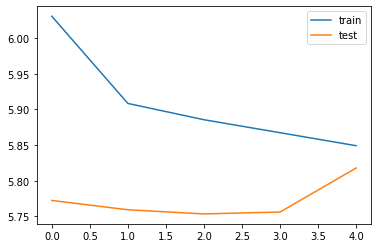

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 4) 인퍼런스 모델 구현
* 학습된 모델(트레이닝 모델)을 이용해 실제 문장을 생성하는 모델(인퍼런스 모델)을 구현해야 한다.
* 트레이닝 모델이 '정답 문장'(target)을 모델 자신의 출력과 비교해가며 학습을 진행하는 반면, 인퍼런스 모델은 정답이 없으므로 문장을 완성할 때까지 디코더가 반복 구조로 동작하는 구조로 별도로 구현되어야 한다.

In [43]:
# 원문 단어 사전
src_word_to_index = src_tokenizer.word_index 
src_index_to_word = src_tokenizer.index_word 

# 요약문 단어 사전
tar_word_to_index = tar_tokenizer.word_index 
tar_index_to_word = tar_tokenizer.index_word

In [44]:
# 인코더 
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 디코더
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
                      [decoder_outputs2] + [state_h2, state_c2])


## 4. 추상적 요약과 원문 비교

In [45]:
# 예측한 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], )
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [47]:
for i in range(20,30):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former us president barack obama said friday president donald trump symptom cause division polarisation us also said trump politicians years added normal urged people vote november elections 
실제 요약 : trump the not cause of division in us obama 
예측 요약 :  india to to to to in in


원문 : bihar police allegedly gave alcohol two daily wage workers carrying woman semi body bamboo pole post mortem workers initially refused carry body due foul smell emanating agreed police offered alcohol consuming alcohol punishable offence attracting year jail term bihar 
실제 요약 : police offer workers alcohol to carry dead body in dry bihar 
예측 요약 :  india to to to to in


원문 : lyricist javed akhtar said whether masjid mandir church gurudwara prayers disturb anybody javed said asked singer sonu nigam comments demanding ban loudspeakers religious sermons earlier sonu tweeted muslim woken azaan called forced religiousness 
실제 요약 : prayers shouldn disturb anybody javed on sonu azaan row 
예측 요약 :  india to to

In [48]:
# src_tokenizer 내부 단어장 인덱스와 단어 확인

for idx in src_tokenizer.index_word:
    print(idx, ":", src_tokenizer.index_word[idx])

    if idx >= 10: break

1 : said
2 : india
3 : year
4 : added
5 : us
6 : also
7 : first
8 : government
9 : police
10 : people


In [49]:
# tar_tokenizer 내부 단어장 인덱스와 단어 확인

for idx in tar_tokenizer.index_word:
    print(idx, ":", tar_tokenizer.index_word[idx])

    if idx >= 10: break

1 : sostoken
2 : eostoken
3 : to
4 : in
5 : for
6 : of
7 : on
8 : india
9 : with
10 : after


맥락과 아무 상관없는 단어들을 나열하고 있다. tokenizer 내부 단어장을 확인했을 때 빈도수가 높았던 india, to, in을 나열하는 것으로 보아 원문의 맥락을 파악하기보다는 가능성 높은 단어들을 적당히 나열하고 있는 것 같다.

앞서 확인한 validation loss도 약 5.75에서 떨어지지 않았다. 노드 실습에서보다 loss가 약 두배 이상 발생하였는데, 데이터의 양과 단어의 수 등이 실습에서보다 훨씬 많았기 때문에 모델 설계도 이를 포괄할 수 있게끔 더 큰 모델로 설계될 필요가 있는듯 보인다.

In [50]:
src_vocab = 22000    # 어휘 사전의 크기
embedding_dim = 256    # 워드 벡터의 차원수(단어들의 인덱스를 워드 벡터로 추상화)
hidden_size = 512    # 단어 간의 연관성(맥락)을 파악하기 위한 LSTM의 수용력(뉴런의 개수, 레이어 깊이)

# 입력 레이어
encoder_inputs = Input(shape=(text_max_len,))

# 임베딩 레이어
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 첫번째 LSTM 레이어
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2, recurrent_dropout = 0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 두번째 LSTM 레이어
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 세번째 LSTM 레이어
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

# 네번째 LSTM 레이어
encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output4, state_h4, state_c4= encoder_lstm4(encoder_output3)

# 다섯번째 LSTM 레이어
encoder_lstm5 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm5(encoder_output4)


# 입력 레이어
decoder_inputs = Input(shape=(None,))

# 임베딩 레이어
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM 레이어
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 레이어
attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 출력 레이어
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

In [51]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 256)      5632000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 512), (N 1574912     embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 45, 512), (N 2099200     lstm_4[0][0]                     
____________________________________________________________________________________________

**워드 벡터의 차원수를 256으로 늘리고, 인코더의 LSTM 레이어를 5개로 늘려 더욱 깊은 구조**를 가질 수 있게 했다. 파라미터 수가 22,323,448개에서 31,270,136개로 늘었다.

In [52]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), 
                    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 356s 1s/step - loss: 6.0338 - val_loss: 5.7916
Epoch 2/50
304/304 [==============================] - 345s 1s/step - loss: 5.8841 - val_loss: 5.7519
Epoch 4/50
304/304 [==============================] - 341s 1s/step - loss: 5.8632 - val_loss: 5.7599
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


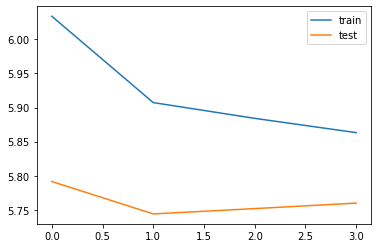

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [54]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian cab hailing startup ola lost fourth billion overall funds raised investors since inception compete american counterpart uber according bloomberg counter rival ola spent nearly crore around million financial year ended march notably ola uber backed japanese conglomerate softbank 
실제 요약 : ola lost th of billion funding to counter uber report 
예측 요약 :  india to to to to in in


원문 : american civil rights activist martin luther king jr sent anonymous letter federal bureau investigation encouraging commit suicide letter aimed nobel laureate claiming intimate knowledge sex life martin luther led non violent struggle equal civil rights african americans us 
실제 요약 : fbi once sent letter to martin him for suicide 
예측 요약 :  india to to to to in in


원문 : american tennis player sloane stephens winner us open women singles title ranked six weeks ago due long injury stephens came us open unseeded became second unseeded us open women champion open era title stephens rise th position mond

loss에도 요약 결과에도 거의 차이를 보이지 않는다. **인코더의 깊이를 깊게 만드는 것은 해결책이 되지 않았다.**  [단어 생성 이력을 이용한 시퀀스-투-시퀀스 요약의
어휘 반복 문제 해결](https://www.koreascience.or.kr/article/CFKO201832073078591.pdf) 논문에 의하면 seq2seq의 성능을 높이기 위하여 디코더가 단어를 생성할 때 인코더의 어느 부분에 집중해야할지를 계산하여 단어 생성 시 추가 정보를 주는 주의집중(attention) 기법이 성능 향상에 도움을 주었으나, 어텐션 기법은 입력문서의 한 부분에 집중되어 어휘 반복 문제를 야기하기도 한다고 지적하고 있다. 

In [55]:
src_vocab = 22000    # 어휘 사전의 크기
embedding_dim = 256    # 워드 벡터의 차원수(단어들의 인덱스를 워드 벡터로 추상화)
hidden_size = 512    # 단어 간의 연관성(맥락)을 파악하기 위한 LSTM의 수용력(뉴런의 개수, 레이어 깊이)

# 입력 레이어
encoder_inputs = Input(shape=(text_max_len,))

# 임베딩 레이어
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 첫번째 LSTM 레이어
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2, recurrent_dropout = 0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 두번째 LSTM 레이어
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 세번째 LSTM 레이어
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

# 네번째 LSTM 레이어
encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)


# 입력 레이어
decoder_inputs = Input(shape=(None,))

# 임베딩 레이어
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM 레이어
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 출력 레이어
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [56]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 45, 256)      5632000     input_8[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 45, 512), (N 1574912     embedding_4[0][0]                
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 45, 512), (N 2099200     lstm_10[0][0]                    
____________________________________________________________________________________________

In [57]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), 
                    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 277s 876ms/step - loss: 6.0426 - val_loss: 5.7613
Epoch 2/50
304/304 [==============================] - 264s 869ms/step - loss: 5.9056 - val_loss: 5.7572
Epoch 3/50
304/304 [==============================] - 261s 860ms/step - loss: 5.8998 - val_loss: 5.7500
Epoch 4/50
304/304 [==============================] - 261s 859ms/step - loss: 5.8723 - val_loss: 5.7679
Epoch 5/50
304/304 [==============================] - 262s 863ms/step - loss: 5.8549 - val_loss: 5.7695
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


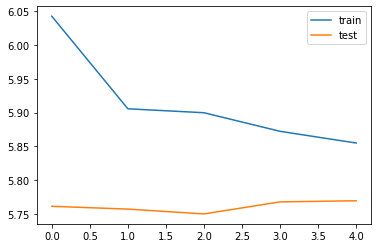

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [59]:
for i in range(20,30):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former us president barack obama said friday president donald trump symptom cause division polarisation us also said trump politicians years added normal urged people vote november elections 
실제 요약 : trump the not cause of division in us obama 
예측 요약 :  india to to to to in in


원문 : bihar police allegedly gave alcohol two daily wage workers carrying woman semi body bamboo pole post mortem workers initially refused carry body due foul smell emanating agreed police offered alcohol consuming alcohol punishable offence attracting year jail term bihar 
실제 요약 : police offer workers alcohol to carry dead body in dry bihar 
예측 요약 :  india to to to to in


원문 : lyricist javed akhtar said whether masjid mandir church gurudwara prayers disturb anybody javed said asked singer sonu nigam comments demanding ban loudspeakers religious sermons earlier sonu tweeted muslim woken azaan called forced religiousness 
실제 요약 : prayers shouldn disturb anybody javed on sonu azaan row 
예측 요약 :  india to to

논문에서 지적한 대로 어휘 반복 현상이 어텐션 기법에 의한 것인지 알아보기 위해 **디코더에서 어텐션 레이어를 제외하고 시도해 보았다.** (실습에 비해 많아진 데이터 양을 고려해 인코더의 LSTM 레이어는 4개로 늘렸다.) 해결되지 않았다. 논문에서는 제시한 해결책은 요약글이 어느정도 완성되었으나 중간에 특정 단어가 반복되는 현상이 나타날 때 적용가능한 해결책을 제시하였지만, 처음부터 입력된 문장과 상관없이 같은 단어만 출력되는 문제는 모델의 문제보다는 오류사항으로 보인다..

## 5. 추출적 요약과 원문 비교
핵심문장을 판별하는 문장 분류(Text Classification) 문제에 해당함.
* 패키지 Summa에서 제공하는 모듈 summarize()를 이용

In [60]:
import requests
from summa.summarizer import summarize

In [61]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

for i in range(10):
    print(data['headlines'][i])
    print(summarize(data['text'][i], ratio=0.5))
    print("====================================")

upGrad learner switches to career in ML & Al with 90% salary hike
upGrad's Online Power Learning has powered 3 lakh+ careers.
Delhi techie wins free food from Swiggy for one year on CRED
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
New Zealand end Rohit Sharma-led India's 12-match winning streak
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
Aegon life iTerm insurance plan helps customers save tax
Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.
Have known Hirani for yrs, what if MeToo claims are not true: Sonam
Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo movemen

본문의 길이가 평균 35단어 수준으로 그리 길지 않으므로 summarize의 ratio 인자를 너무 작게 입력할 경우 문장을 아예 골라내지 못하는 경우가 있어 0.5로 설정하였다. 실제 요약문(headline)과 그리 일치하는 것으로 보이지는 않는다. 새로 쓰는 뉴스 기사의 헤드라인과 단순 특정 문장을 골라내는 것에는 차이가 있을 수 밖에 없고, 해당 데이터와 같이 본문 자체가 짧은 경우 ratio 또는 words 인자를 조절하며 문장을 고르게끔 하면 거의 본문 그대로를 옮기는 것과 마찬가지이기 때문에, 추출적 요약은 본문 길이가 아주 길 경우에 유용한 방법이 된다고 여겨진다.

## 회고

- 처음으로 멀쩡한 결과물 내기를 중도 포기했다..  무슨 수를 써야 loss를 더 떨어뜨릴 수 있는지, loss가 일정 수준 이상으로 떨어지면 적절한 문장이 나오기는 하는지 의문이 든다.....
- 인코더, 디코더, 인퍼런스 모델까지 어느 지점에서 문제가 발생한 것인지 짐작하기 어렵다. 어떤 입력이 들어오든 계속 같은 단어만 추정하고 있다는 점에서 인코더의 문제인지, 아니면 디코더가 적절한 다음 단어를 추정하지 못하고 있는 건지, 학습 결과를 이용해 단어를 생성해야 하는 인퍼런스 모델이 학습 결과를 전혀 쓰지 못하고 있을 뿐인지...... 